# Measuring the covariance/correlation between features

In this notebook we measure the correlation between features.

## Import libraries and data

Data has been restricted to stroke teams with at least 300 admissions, with at least 10 patients receiving thrombolysis, over three years.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn.preprocessing import StandardScaler

# Import data (combine all data)
train = pd.read_csv('../data/10k_training_test/cohort_10000_train.csv')
test = pd.read_csv('../data/10k_training_test/cohort_10000_test.csv')
data = pd.concat([train, test], axis=0)
data.drop('StrokeTeam', axis=1, inplace=True)

In [2]:
data

,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,MotorArmLeft,...,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis
0,72.5,49.0,1,0,0.0,0.0,0.0,0.0,3.0,4.0,...,0,1,0,1,0,0,0,0,1,0
1,77.5,96.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,77.5,77.0,0,0,2.0,1.0,1.0,2.0,1.0,0.0,...,0,1,1,0,0,0,0,0,1,1
3,82.5,142.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,1,0,0,0,0,0,1,1
4,87.5,170.0,0,0,0.0,0.0,1.0,1.0,2.0,4.0,...,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,57.5,99.0,0,1,2.0,2.0,1.0,2.0,2.0,0.0,...,0,1,0,1,0,0,0,0,1,0
9996,87.5,159.0,3,0,2.0,2.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,0,1,1
9997,67.5,142.0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
9998,72.5,101.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,1,0,0,0,0,0,1,0


## Scale data

After scaling data, the reported covariance will be the correlation between data features.

In [3]:
sc=StandardScaler() 
sc.fit(data)
data_std=sc.transform(data)
data_std = pd.DataFrame(data_std, columns =list(data))

## Get covariance of scaled data (correlation)

In [4]:
# Get covariance
cov = data_std.cov()

# Convert from wide to tall
cov = cov.melt(ignore_index=False)

# Remove self-correlation
mask = cov.index != cov['variable']
cov = cov[mask]

# Add absolute value
cov['abs_value'] = np.abs(cov['value'])

# Add R-squared
cov['r-squared'] = cov['value'] ** 2

# Sort by absolute covariance
cov.sort_values('abs_value', inplace=True, ascending=False)

# Round to four decimal places
cov = cov.round(4)

# Label rows where one of the feature pairs tags data as 'missing'
result = []
for index, values in cov.iterrows():
    if index[-7:] == 'missing' or values['variable'][-7:] == 'missing':
        result.append(True)
    else:
        result.append(False)
cov['missing'] = result

# Remove duplicate pairs of features
result = []
for index, values in cov.iterrows():
    combination = [index, values['variable']]
    combination.sort()
    string = combination[0] + "-" + combination[1]
    result.append(string)
cov['pair'] = result
cov.sort_values('pair', inplace=True)
cov.drop_duplicates(subset=['pair'], inplace=True)

# Sort by r-squared
cov.sort_values('r-squared', ascending=False, inplace=True)

In [5]:
cov

,variable,value,abs_value,r-squared,missing,pair
AFAnticoagulentHeparin_missing,AFAnticoagulentDOAC_missing,1.0000,1.0000,1.0,True,AFAnticoagulentDOAC_missing-AFAnticoagulentHep...
Hypertension_Yes,Hypertension_No,-1.0000,1.0000,1.0,False,Hypertension_No-Hypertension_Yes
AFAnticoagulentHeparin_missing,AFAnticoagulentVitK_missing,1.0000,1.0000,1.0,True,AFAnticoagulentHeparin_missing-AFAnticoagulent...
AFAnticoagulentDOAC_missing,AFAnticoagulentVitK_missing,1.0000,1.0000,1.0,True,AFAnticoagulentDOAC_missing-AFAnticoagulentVit...
S1ArriveByAmbulance_Yes,S1ArriveByAmbulance_No,-1.0000,1.0000,1.0,False,S1ArriveByAmbulance_No-S1ArriveByAmbulance_Yes
...,...,...,...,...,...,...
Hypertension_No,S1OnsetInHospital_Yes,0.0000,0.0000,0.0,False,Hypertension_No-S1OnsetInHospital_Yes
S1OnsetTimeType_Not known,Hypertension_No,0.0000,0.0000,0.0,False,Hypertension_No-S1OnsetTimeType_Not known
S2BrainImagingTime_min,Hypertension_No,0.0066,0.0066,0.0,False,Hypertension_No-S2BrainImagingTime_min
Hypertension_No,S2NihssArrival,-0.0009,0.0009,0.0,False,Hypertension_No-S2NihssArrival


In [6]:
# Save results
cov.to_csv('./output/feature_correlation.csv')

## Show histogram and counts of correlations

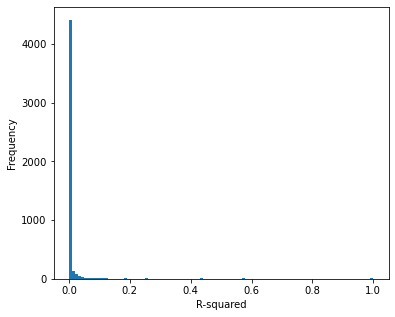

In [7]:
# Histogram of covariance/correlation
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
bins = np.arange(0, 1.01, 0.01)
ax.hist(cov['r-squared'], bins=bins, rwidth=1)
ax.set_xlabel('R-squared') 
ax.set_ylabel('Frequency')
plt.savefig('output/covariance.jpg', dpi=300)
plt.show()

Show proportion of feature correlations (R-sqaured)in key bins

In [8]:
bins = [0, 0.10, 0.25, 0.5, 0.75, 0.99, 1.1]
counts = np.histogram(cov['r-squared'], bins=bins)[0]
counts = counts / counts.sum()

labels = ['<0.10', '0.1 to 0.25', '0.25 to 0.50', '0.50 to 0.75', '0.75 to 0.999', '1']
counts_df = pd.DataFrame(index=labels)
counts_df['Proportion'] = counts
counts_df['Cumulative Proportion'] = counts.cumsum()
counts_df.index.name = 'R-squared'
counts_df

,Proportion,Cumulative Proportion
R-squared,,
<0.10,0.960808,0.960808
0.1 to 0.25,0.015556,0.976364
0.25 to 0.50,0.010303,0.986667
0.50 to 0.75,0.006667,0.993333
0.75 to 0.999,0.003232,0.996566
1,0.003434,1.000000


## Show highly correlated features

### Perfectly correlated features

In [9]:
# Get perfectly correlated data (covariance > 0.999)
mask = cov['r-squared'] > 0.999
cov[mask]

,variable,value,abs_value,r-squared,missing,pair
AFAnticoagulentHeparin_missing,AFAnticoagulentDOAC_missing,1.0,1.0,1.0,True,AFAnticoagulentDOAC_missing-AFAnticoagulentHep...
Hypertension_Yes,Hypertension_No,-1.0,1.0,1.0,False,Hypertension_No-Hypertension_Yes
AFAnticoagulentHeparin_missing,AFAnticoagulentVitK_missing,1.0,1.0,1.0,True,AFAnticoagulentHeparin_missing-AFAnticoagulent...
AFAnticoagulentDOAC_missing,AFAnticoagulentVitK_missing,1.0,1.0,1.0,True,AFAnticoagulentDOAC_missing-AFAnticoagulentVit...
S1ArriveByAmbulance_Yes,S1ArriveByAmbulance_No,-1.0,1.0,1.0,False,S1ArriveByAmbulance_No-S1ArriveByAmbulance_Yes
MoreEqual80y_No,MoreEqual80y_Yes,-1.0,1.0,1.0,False,MoreEqual80y_No-MoreEqual80y_Yes
Diabetes_Yes,Diabetes_No,-1.0,1.0,1.0,False,Diabetes_No-Diabetes_Yes
S1Gender_Male,S1Gender_Female,-1.0,1.0,1.0,False,S1Gender_Female-S1Gender_Male
CongestiveHeartFailure_Yes,CongestiveHeartFailure_No,-1.0,1.0,1.0,False,CongestiveHeartFailure_No-CongestiveHeartFailu...
AtrialFibrillation_Yes,AtrialFibrillation_No,-1.0,1.0,1.0,False,AtrialFibrillation_No-AtrialFibrillation_Yes


### Highly correlated features

R-squared between 0.5 and 0.999

In [10]:
# Get highly correlated data (covariance between 0.50 and 0.999)
pd.set_option('display.max_rows', None)
mask = (cov['abs_value'] <= 0.999) & (cov['abs_value'] >= 0.50)
cov[mask]

,variable,value,abs_value,r-squared,missing,pair
AFAnticoagulentHeparin_No,AFAnticoagulentHeparin_missing,-0.9984,0.9984,0.9969,True,AFAnticoagulentHeparin_No-AFAnticoagulentHepar...
AFAnticoagulentDOAC_missing,AFAnticoagulentHeparin_No,-0.9984,0.9984,0.9969,True,AFAnticoagulentDOAC_missing-AFAnticoagulentHep...
AFAnticoagulentVitK_missing,AFAnticoagulentHeparin_No,-0.9984,0.9984,0.9969,True,AFAnticoagulentHeparin_No-AFAnticoagulentVitK_...
S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,-0.9940,0.9940,0.9881,False,S2StrokeType_Infarction-S2StrokeType_Primary I...
AFAnticoagulentVitK_missing,AFAnticoagulentVitK_No,-0.9590,0.9590,0.9198,True,AFAnticoagulentVitK_No-AFAnticoagulentVitK_mis...
AFAnticoagulentVitK_No,AFAnticoagulentHeparin_missing,-0.9590,0.9590,0.9198,True,AFAnticoagulentHeparin_missing-AFAnticoagulent...
AFAnticoagulentVitK_No,AFAnticoagulentDOAC_missing,-0.9590,0.9590,0.9198,True,AFAnticoagulentDOAC_missing-AFAnticoagulentVit...
AFAnticoagulentHeparin_No,AFAnticoagulentVitK_No,0.9575,0.9575,0.9168,False,AFAnticoagulentHeparin_No-AFAnticoagulentVitK_No
S2NewAFDiagnosis_No,S2NewAFDiagnosis_missing,-0.9423,0.9423,0.8880,True,S2NewAFDiagnosis_No-S2NewAFDiagnosis_missing
AFAnticoagulentDOAC_No,AFAnticoagulentDOAC_missing,-0.9339,0.9339,0.8721,True,AFAnticoagulentDOAC_No-AFAnticoagulentDOAC_mis...


Repeat (covariance between 0.50 and 0.999), but exclude when one of the data pairs is tagged as 'missing' data.

In [11]:
# Get highly correlated data (covariance between 0.50 and 0.999)
pd.set_option('display.max_rows', None)
mask = (cov['abs_value'] <= 0.999) & (cov['abs_value'] >= 0.50) & (cov['missing'] == False)
cov[mask]

,variable,value,abs_value,r-squared,missing,pair
S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,-0.9940,0.9940,0.9881,False,S2StrokeType_Infarction-S2StrokeType_Primary I...
AFAnticoagulentHeparin_No,AFAnticoagulentVitK_No,0.9575,0.9575,0.9168,False,AFAnticoagulentHeparin_No-AFAnticoagulentVitK_No
AFAnticoagulentDOAC_No,AFAnticoagulentHeparin_No,0.9322,0.9322,0.8690,False,AFAnticoagulentDOAC_No-AFAnticoagulentHeparin_No
AFAnticoagulentDOAC_No,AFAnticoagulentVitK_No,0.8889,0.8889,0.7902,False,AFAnticoagulentDOAC_No-AFAnticoagulentVitK_No
S1AdmissionYear_2018,AFAnticoagulentHeparin_No,0.8758,0.8758,0.7671,False,AFAnticoagulentHeparin_No-S1AdmissionYear_2018
MotorLegRight,MotorArmRight,0.8435,0.8435,0.7115,False,MotorArmRight-MotorLegRight
AFAnticoagulentVitK_No,S1AdmissionYear_2018,0.8370,0.8370,0.7006,False,AFAnticoagulentVitK_No-S1AdmissionYear_2018
MotorArmLeft,MotorLegLeft,0.8326,0.8326,0.6933,False,MotorArmLeft-MotorLegLeft
S1AdmissionYear_2018,AFAnticoagulentDOAC_No,0.8108,0.8108,0.6574,False,AFAnticoagulentDOAC_No-S1AdmissionYear_2018
S2NewAFDiagnosis_No,AFAnticoagulentDOAC_No,0.7859,0.7859,0.6176,False,AFAnticoagulentDOAC_No-S2NewAFDiagnosis_No


## Observations

* Most of the features show weak correlation (96% of feature pairs have an R-squared of less than 0.1)

* Perfectly correlated feature pairs ar epresent due to dichotomised coding of some features.

* Many highly correlated features are due to correlaytions between missing data and the value if data is present. There are some 'more interesting' highly correlated data such as:
    
    * Right leg and arm weakness is are highly correlated, as are left leg and arm weakness.
    * Right leg weakness is highly correlated with problems in balance and language.